Score Category 0:
H_mean         63.869205
S_mean         59.247254
V_mean        141.570880
I1_mean        45.826219
I2_mean        56.414396
I3_mean        24.577271
L_mean         45.826219
S_lst_mean      5.273337
T_mean        112.828791
Name: 0, dtype: float64


Score Category 1:
H_mean         59.648873
S_mean         66.859117
V_mean        139.686261
I1_mean        45.791436
I2_mean        51.334073
I3_mean        22.715751
L_mean         45.791436
S_lst_mean      5.373644
T_mean        102.668145
Name: 1, dtype: float64


Score Category 2:
H_mean         57.519464
S_mean         71.524723
V_mean        139.252184
I1_mean        45.807985
I2_mean        48.860708
I3_mean        21.836379
L_mean         45.807985
S_lst_mean      5.433682
T_mean         97.721416
Name: 2, dtype: float64


Score Category 3:
H_mean         56.141954
S_mean         75.105693
V_mean        139.041323
I1_mean        45.526977
I2_mean        47.542561
I3_mean        21.386805
L_mean         45.526977


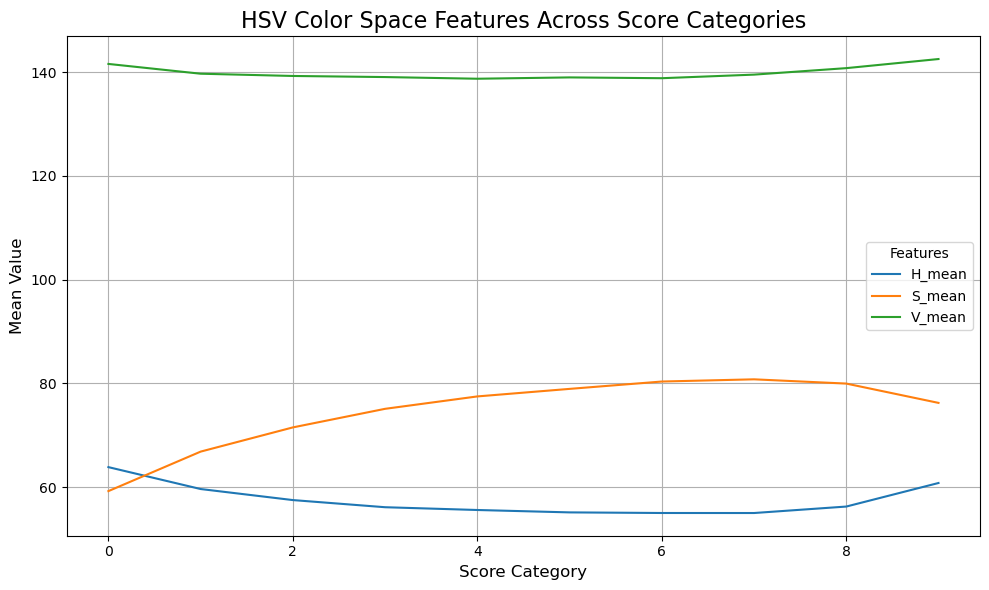

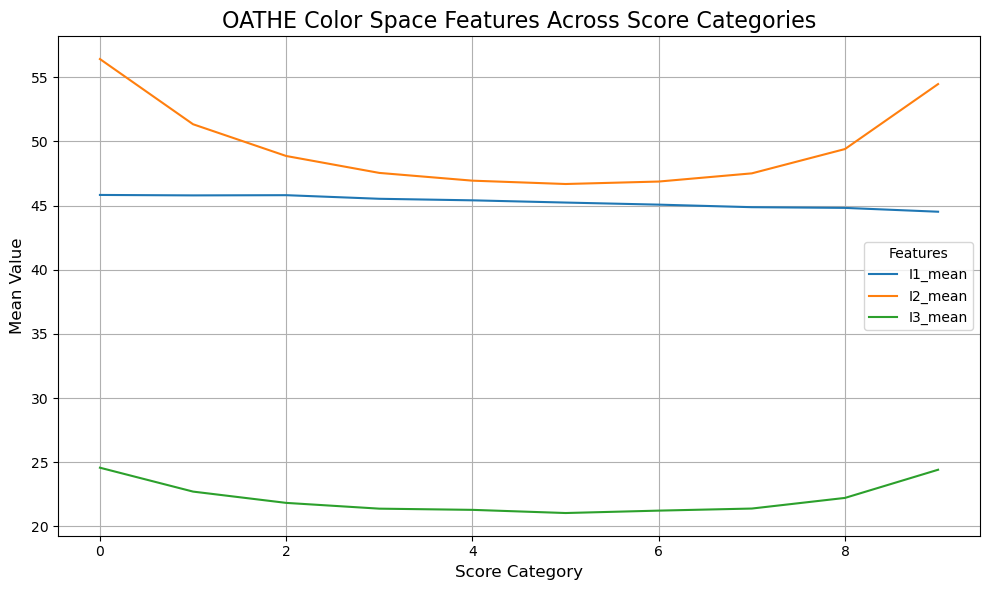

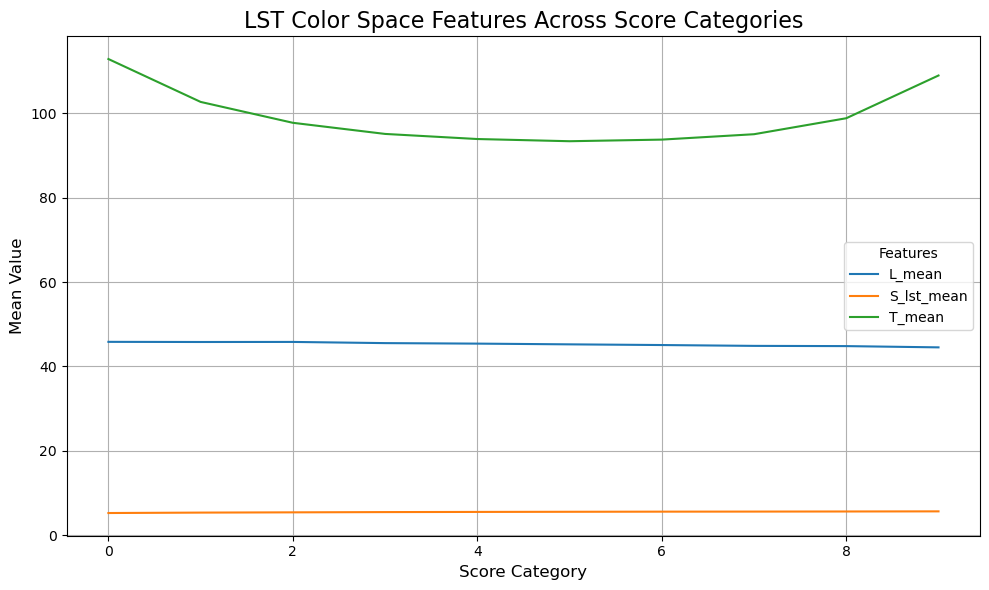

In [10]:
import pandas as pd
from collections import Counter
import os

# Read the score data
df_scores = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot.metadata.csv')

# Read the color feature data (color space features: H_mean, S_mean, V_mean, etc.)
df_colors = pd.read_csv('/home/ubuntu/landscape-aesthetics/data/external/scenicornot/scenicornot_color_feature.csv')  # Change to the path of your color feature file

# Assume the first column in df_scores is the image name and the 8th column is the score
df_scores = df_scores[['filename', 'average']]  # Extract the columns for image names and scores

# Divide the scores into 10 equal-frequency intervals
df_scores['score_category'] = pd.qcut(df_scores['average'], q=10, labels=False)

df_colors['filename_extracted'] = df_colors['image_path'].apply(os.path.basename)
df_scores['filename_extracted'] = df_scores['filename'].apply(os.path.basename)

# Merge the two dataframes based on the image name
df_merged = pd.merge(df_scores, df_colors, left_on='filename_extracted', right_on='filename_extracted')

# Calculate the mean of each color space feature per score category
color_features = ['H_mean', 'S_mean', 'V_mean', 'I1_mean', 'I2_mean', 'I3_mean', 'L_mean', 'S_lst_mean', 'T_mean']

mean_colors_by_category = df_merged.groupby('score_category')[color_features].mean()

# Output the mean values of the color features for each score category
for category in mean_colors_by_category.index:
    print(f"Score Category {category}:")
    print(mean_colors_by_category.loc[category])
    print("\n")

# Visualize the color features for each score category
import matplotlib.pyplot as plt

hsv_features = ['H_mean', 'S_mean', 'V_mean']

oathe_features = ['I1_mean', 'I2_mean', 'I3_mean']

lst_features = ['L_mean', 'S_lst_mean', 'T_mean']

color_spaces = {
    'HSV': hsv_features,
    'OATHE': oathe_features,
    'LST': lst_features
}

for space_name, features in color_spaces.items():
    plt.figure(figsize=(10, 6))
    for feature in features:
        plt.plot(mean_colors_by_category.index, mean_colors_by_category[feature], label=feature)
    
    plt.title(f'{space_name} Color Space Features Across Score Categories', fontsize=16)
    plt.xlabel('Score Category', fontsize=12)
    plt.ylabel('Mean Value', fontsize=12)
    plt.legend(title='Features')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 定义三个颜色空间特征
hsv_features = ['H_mean', 'S_mean', 'V_mean']
ohta_features = ['I1_mean', 'I2_mean', 'I3_mean']
lst_features = ['L_mean', 'S_lst_mean', 'T_mean']

# 定义要分析的颜色空间
color_spaces = {
    'HSV': hsv_features,
    'Ohta': ohta_features,
    'LST': lst_features
}

# 定义评分列
target_column = 'average'

# 分别进行相关性分析和线性回归
for space_name, features in color_spaces.items():
    print(f"\n===== Analyzing {space_name} Color Space =====")
    
    # 提取当前颜色空间的特征和评分
    df_current_space = df_merged[features + [target_column]]
    
    # 相关性分析
    print(f"\nCorrelation with {target_column}:")
    correlation_matrix = df_current_space.corr()
    print(correlation_matrix[target_column].sort_values(ascending=False))
    
    # 线性回归分析
    X = df_merged[features]  # 自变量为当前颜色空间的特征
    y = df_merged[target_column]  # 因变量为评分

    # 将数据集分为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 创建并训练线性回归模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 进行预测
    y_pred = model.predict(X_test)

    # 输出线性回归模型的系数
    print("\nLinear Regression Coefficients:")
    for feature, coef in zip(features, model.coef_):
        print(f"{feature}: {coef}")

    # 输出模型的均方误差（MSE）和 R^2 评分
    mse = mean_squared_error(y_test, y_pred)
    r2 = model.score(X_test, y_test)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R^2 Score: {r2}")



===== Analyzing HSV Color Space =====

Correlation with average:
average    1.000000
S_mean     0.187241
V_mean     0.016448
H_mean    -0.056378
Name: average, dtype: float64

Linear Regression Coefficients:
H_mean: -0.0010898092597936815
S_mean: 0.010891115997390103
V_mean: 0.0034879971616816993

Mean Squared Error (MSE): 2.445168191926806
R^2 Score: 0.03948247114759296

===== Analyzing Ohta Color Space =====

Correlation with average:
average    1.000000
I3_mean   -0.004027
I2_mean   -0.027365
I1_mean   -0.070329
Name: average, dtype: float64

Linear Regression Coefficients:
I1_mean: -0.01968736922926917
I2_mean: -0.003370536278934909
I3_mean: 0.00032814868418374536

Mean Squared Error (MSE): 2.5298879074098255
R^2 Score: 0.0062026452323437065

===== Analyzing LST Color Space =====

Correlation with average:
average       1.000000
S_lst_mean    0.169602
T_mean       -0.027365
L_mean       -0.070329
Name: average, dtype: float64

Linear Regression Coefficients:
L_mean: -0.00268580271